In [13]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [14]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()

        # input 32 x 3 x 512 x 512

        self.conv1 = nn.Conv2d(3, 3, 3, stride=2, padding=1)   # 3 x 256 x 256
        self.conv2 = nn.Conv2d(3, 32, 3, stride=2, padding=1)   # 32 x 128 x 128
        self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)   # 32 x 64 x 64
        self.conv4 = nn.Conv2d(32, 64, 3, stride=2, padding=1)   # 64 x 32 x 32
        self.conv5 = nn.Conv2d(64, 64, 3, stride=2, padding=1)   # 64 x 16 x 16
        self.conv6 = nn.Conv2d(64, 64, 3, stride=2, padding=1)   # 64 x 8 x 8
        self.conv7 = nn.Conv2d(64, 64, 3, stride=2, padding=1)   # 64 x 4 x 4
        self.conv8 = nn.Conv2d(64, 128, 3, stride=2, padding=1)   # 128 x 2 x 2
        self.linear1 = nn.Linear(128 * 2 * 2, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()  # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to(DEVICE)
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        x = F.leaky_relu(self.conv6(x))
        x = F.leaky_relu(self.conv7(x))
        x = F.leaky_relu(self.conv8(x))
        x = torch.flatten(x, start_dim=1)

        x = F.leaky_relu(self.linear1(x))
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma ** 2 + mu ** 2 - torch.log(sigma) - 1 / 2).sum()
        return z

In [15]:
class Decoder(nn.Module):

    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 512),
            nn.ReLU(True),
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(128, 2, 2))
        self.decoder_conv = nn.Sequential(
            nn.Conv2d(128, 64, 3, stride=1, padding='same'),
            nn.LeakyReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 64, 3, stride=1, padding='same'),
            nn.LeakyReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 64, 3, stride=1, padding='same'),
            nn.LeakyReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 64, 3, stride=1, padding='same'),
            nn.LeakyReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, stride=1, padding='same'),
            nn.LeakyReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 32, 3, stride=1, padding='same'),
            nn.LeakyReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 16, 3, stride=1, padding='same'),
            nn.LeakyReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16, 16, 3, stride=1, padding='same'),
            nn.LeakyReLU(True),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(16, 3, 3, stride=1, padding=1),
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x


In [16]:
class VariationalAutoencoder(nn.Module):
    seed = 0
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(DEVICE)
        z = self.encoder(x)
        return self.decoder(z)

In [17]:
torch.manual_seed(0)

d=512
vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3

optim = torch.optim.AdamW(vae.parameters(), lr=lr, weight_decay=1e-5)

vae.to(DEVICE)

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (linear1): Linear(in_features=512, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (linear3): Linear(in_features=512, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=512, out_features=512,

In [18]:
from torchinfo import summary
summary(vae, input_size=(128, 3, 512, 512))

Layer (type:depth-idx)                   Output Shape              Param #
VariationalAutoencoder                   [128, 3, 512, 512]        --
├─VariationalEncoder: 1-1                [128, 512]                --
│    └─Conv2d: 2-1                       [128, 3, 256, 256]        84
│    └─Conv2d: 2-2                       [128, 32, 128, 128]       896
│    └─Conv2d: 2-3                       [128, 32, 64, 64]         9,248
│    └─Conv2d: 2-4                       [128, 64, 32, 32]         18,496
│    └─Conv2d: 2-5                       [128, 64, 16, 16]         36,928
│    └─Conv2d: 2-6                       [128, 64, 8, 8]           36,928
│    └─Conv2d: 2-7                       [128, 64, 4, 4]           36,928
│    └─Conv2d: 2-8                       [128, 128, 2, 2]          73,856
│    └─Linear: 2-9                       [128, 512]                262,656
│    └─Linear: 2-10                      [128, 512]                262,656
│    └─Linear: 2-11                      [128, 512]

In [19]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    pbar = tqdm(dataloader)
    for x, _ in pbar:
        optimizer.zero_grad()
        x = x.to(device)
        with torch.cuda.amp.autocast():
            x_hat = vae(x)
            loss = loss = ((x - x_hat)**2).sum() + vae.encoder.kl
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # Move tensor to the proper device
        #x = x.to(device)
        #x_hat = vae(x)
        # Evaluate loss
        #loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()
        # Print batch loss
        pbar.set_description('Batch loss: %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [20]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [21]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

data_dir = '/mnt/c/Datasets/flickrfaces/splits/'

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = ImageFolder(data_dir + "train/", train_transform)

val_dataset = ImageFolder(data_dir + "val/", train_transform)

test_dataset = ImageFolder(data_dir + "test/", test_transform)
m=len(train_dataset)

batch_size=128
num_workers=8

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,num_workers=num_workers, shuffle=True)

In [22]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

def plot_ae_outputs(n=10):
    fig = plt.figure(figsize=(16,4.5))
    sample_batch = next(iter(train_loader))[0]
    images = sample_batch.permute(0,2,3,1).numpy()
    outputs = vae(sample_batch).permute(0,2,3,1).detach().cpu().numpy()
    grid = ImageGrid(fig, 111, nrows_ncols=(2, n), axes_pad=0.1)
    for ax, im in zip(grid, np.concatenate((images[0:n], outputs[0:n]), axis=0)):
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(im)

    plt.show()
    fig.clear()
    plt.close(fig)

In [23]:
torch.backends.cudnn.benchmark = True

Started training...


Batch loss: 1540484.500000: 100%|██████████| 438/438 [04:40<00:00,  1.56it/s]



 EPOCH 1/50 	 train loss 36749.128 	 val loss 24209.566


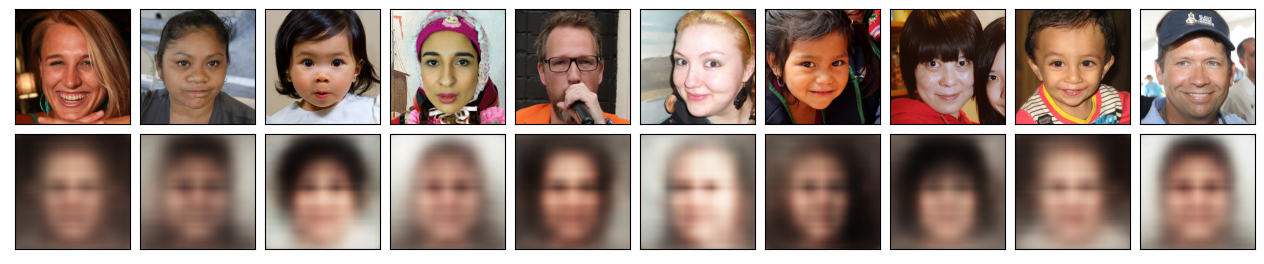

Batch loss: 1293996.000000: 100%|██████████| 438/438 [05:01<00:00,  1.45it/s]



 EPOCH 2/50 	 train loss 21951.154 	 val loss 20042.783


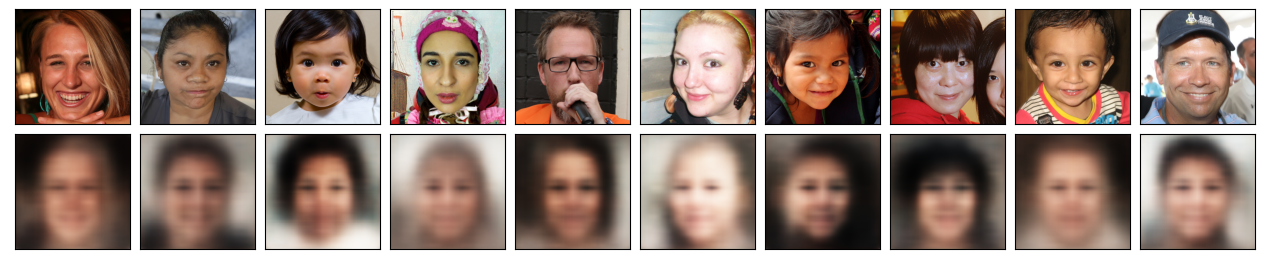

Batch loss: 2474281.250000:  10%|▉         | 42/438 [00:29<03:50,  1.72it/s]

In [ ]:
num_epochs = 50
scaler = torch.cuda.amp.GradScaler()
print("Started training...")
for epoch in range(num_epochs):
    train_loss = train_epoch(vae,DEVICE,train_loader,optim)
    val_loss = test_epoch(vae,DEVICE,valid_loader)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs(n=10)